In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse import lil_matrix
import scipy.sparse as sc
import scipy.sparse.linalg as la
import time

In [3]:
def create_poisson_matrix(n):
    # Create the diagonals for the Poisson matrix
    main_diag = -4 * np.ones(n**2)
    side_diag = np.ones(n**2 - 1)
    top_bottom_diag = np.ones(n**2 - n)
    
    # Create a sparse matrix with these diagonals
    diagonals = [main_diag, side_diag, side_diag, top_bottom_diag, top_bottom_diag]
    offsets = [0, 1, -1, n, -n]
    poisson_matrix = diags(diagonals, offsets, shape=(n**2, n**2), format='lil')
    
    # Convert to a dense matrix
    poisson_matrix = poisson_matrix.toarray()

    return poisson_matrix


In [4]:
# Compute nested dissection permutation
def compute_nd(k):
    # Computes permutation for nested dissection on (2^k-1)x(2^k-1) meshes

    if k<1:
        # Trap nonsense input
        print("Makes no sense!")
        return None
    elif k == 1:
        # order for 1x1 matrix
        return np.zeros(1,dtype=int)
    else:
        # Compute relevant sizes
        n_small = 2**(k-1)-1
        n_small_sq = n_small**2
        n_big = 2**k-1

        # Compute permutation for subproblems, invert, and cast to square array
        iperm1 = compute_nd(k-1)
        perm1 = np.zeros_like(iperm1)
        perm1[iperm1] = np.arange(n_small_sq)
        perm1_2d = perm1.reshape(n_small,n_small)

        # Create empty 2D array to store permutation
        perm_2d = np.zeros((n_big,n_big),dtype=int)

        # Indices to grab/use
        small_range = np.arange(n_small)
        small_range_shift = np.arange(n_small+1,n_big)
        big_range = np.arange(n_big)

        # Now set up 2D big permutation by copying and shifting
        perm_2d[small_range[:,None],small_range] = perm1_2d
        perm_2d[small_range[:,None],small_range_shift] = perm1_2d + n_small_sq
        perm_2d[small_range_shift[:,None],small_range] = perm1_2d + 2*n_small_sq
        perm_2d[small_range_shift[:,None],small_range_shift] = perm1_2d + 3*n_small_sq
        
        # Number the central cross
        perm_2d[small_range,n_small] = 4*n_small_sq + small_range
        perm_2d[n_small,big_range] = 4*n_small_sq+n_small+big_range
        perm_2d[small_range_shift,n_small] = 4*n_small_sq+n_small+n_big+small_range

        # Now invert the permutation and return
        iperm = np.zeros(n_big**2,dtype=int)
        iperm[perm_2d.reshape(n_big**2)] = np.arange(n_big**2)
        
        return iperm

In [5]:
# manually choose value of L
L = 6
n =  2**L - 1

In [6]:
A = create_poisson_matrix(n)

In [7]:
perm = compute_nd(L)

In [8]:
perm_inv = np.zeros_like(perm)
perm_inv[perm] = np.arange(np.size(perm))
A_reorder = A[perm[:, None], perm]

L = 6 , n = 63


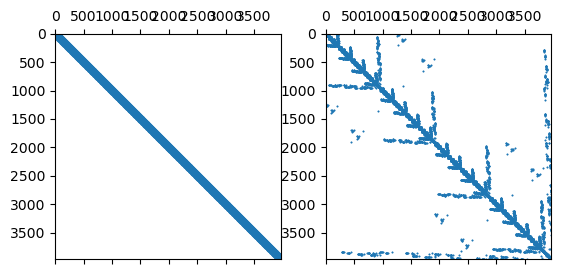

In [9]:
print("L =", L, ", n =", n)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(A, marker = "s",markersize = 0.5)
ax2.spy(A_reorder, marker = "s", markersize = 0.5)

In [10]:
A = sc.csc_matrix(A)
start_time1 = time.time()
B = la.splu(A)
end_time1 = time.time()
elapsed_time1 = end_time1 - start_time1
print("Natural:", elapsed_time1)

Natural: 0.010654926300048828


In [11]:
A_reorder = sc.csc_matrix(A_reorder)
start_time2 = time.time()
C = la.splu(A_reorder, permc_spec="NATURAL")
end_time2 = time.time()
elapsed_time2 = end_time2 - start_time2
print("Reorder:", elapsed_time2)

Reorder: 0.011540889739990234


In [43]:
normal_cost = []
nd_cost = []
for l in np.arange(3, 8):
    n =  2**l - 1
    
    A = create_poisson_matrix(n)
    perm = compute_nd(l)
    perm_inv = np.zeros_like(perm)
    perm_inv[perm] = np.arange(np.size(perm))
    A_reorder = A[perm[:, None], perm]
    
    time1 = 0
    time2 = 0
    for ite in range(1):
        A = sc.csc_matrix(A)
        start_time1 = time.time()
        B = la.splu(A)
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time1
        time1 += elapsed_time1

        A_reorder = sc.csc_matrix(A_reorder)
        start_time2 = time.time()
        C = la.splu(A_reorder, permc_spec="NATURAL")
        end_time2 = time.time()
        elapsed_time2 = end_time2 - start_time2
        time2 += elapsed_time2
    
    normal_cost.append(time1/1)
    nd_cost.append(time2/1)

Text(0.5, 1.0, 'Factorization Cost for Each Values of L')

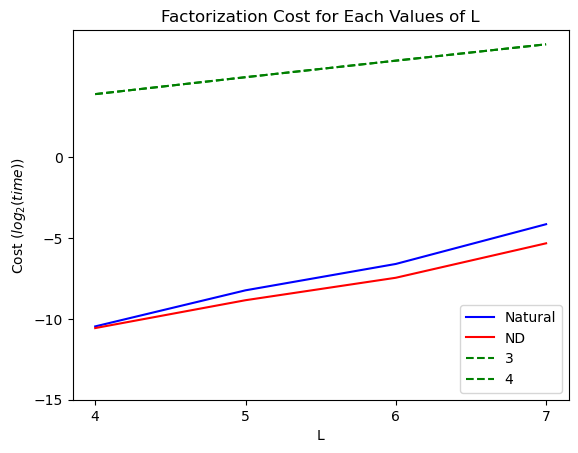

In [91]:
l = np.arange(4, 8)
plt.plot(l, np.log2(normal_cost[1:]), color='blue', label="Natural")
plt.plot(l, np.log2(nd_cost[1:]), color='red', label="ND")
plt.legend()
plt.xlabel("L")
plt.ylabel("Cost ($log_{2}{(time)}$)")
plt.xticks(l)
plt.yticks([-15, -10, -5, 0])
plt.title("Factorization Cost for Each Values of L")

In [88]:
normal_cost

[0.0021491050720214844,
 0.0007078647613525391,
 0.003326892852783203,
 0.010307073593139648,
 0.056674957275390625]

In [89]:
nd_cost

[0.0022509098052978516,
 0.0006589889526367188,
 0.002177000045776367,
 0.011404037475585938,
 0.07066488265991211]